In [130]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [131]:
df = pd.read_csv (r'HXPC13_DI_v3_11-13-2019.csv')

In [132]:
df.head(5)

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,1,0,0,0,United States,NaN,NaN,NaN,0,12/19/12,11/17/13,NaN,9.0,NaN,NaN,0,NaN,1.0
1,HarvardX/CB22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2/8/13,11/17/13,NaN,16.0,NaN,NaN,0,NaN,1.0
2,HarvardX/CB22x/2013_Spring,MHxPC130539455,1,1,0,0,France,NaN,NaN,NaN,0,1/1/13,5/14/13,42.0,6.0,NaN,3.0,0,NaN,NaN
3,HarvardX/CB22x/2013_Spring,MHxPC130088379,1,1,0,0,United States,NaN,NaN,NaN,0,2/18/13,3/17/13,70.0,3.0,NaN,3.0,0,NaN,NaN
4,HarvardX/CB22x/2013_Spring,MHxPC130024894,1,1,0,0,United States,NaN,NaN,NaN,0.07,1/24/13,8/3/13,175.0,9.0,NaN,7.0,0,NaN,NaN


### Descriptive statistics

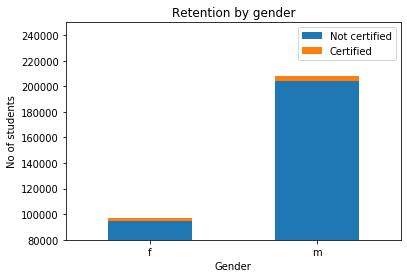

In [133]:
df_gender = df.groupby(['gender','certified'])['course_id'].count().unstack().head(2)
gender_plot = df_gender.plot(kind='bar',stacked=True,title="Retention by gender",rot=0)
gender_plot.set_xlabel("Gender")
gender_plot.set_ylabel("No of students")
gender_plot.set_ylim((80000, 250000))
gender_plot.legend(["Not certified","Certified"]);

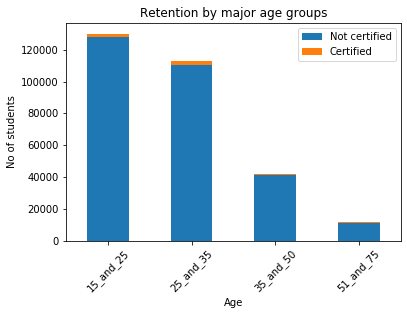

In [134]:
#add age column
df['age'] = 2013- df['YoB']
#add age bucket
df.loc[((df['age'] >= 15) & (df['age'] <= 25) ), 'age_bucket'] = '15_and_25'
df.loc[((df['age'] > 25) & (df['age'] <= 35) ), 'age_bucket'] = '25_and_35'
df.loc[((df['age'] > 35) & (df['age'] <= 50) ), 'age_bucket'] = '35_and_50'
df.loc[((df['age'] > 51) & (df['age'] <= 75) ), 'age_bucket'] = '51_and_75'

#plot
df_age = df.groupby(['age_bucket','certified'])['course_id'].count().unstack()
age_plot = df_age.plot(kind='bar',stacked=True,title="Retention by major age groups",rot=45)
age_plot.set_xlabel("Age")
age_plot.set_ylabel("No of students")
#age_plot.set_ylim((1000, 250000))
age_plot.legend(["Not certified","Certified"]);

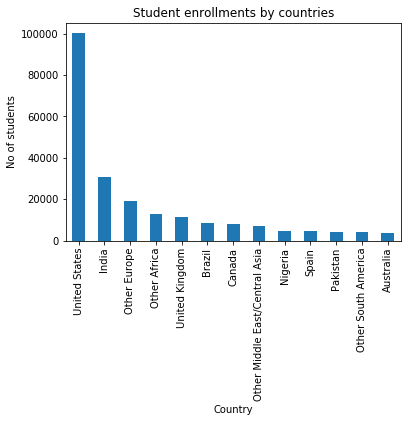

In [135]:
#Top countries by student registration
df_country = df.loc[df['final_cc_cname_DI'].isin(['United States','India','Other Europe','Other Africa','United Kingdom'
                                                 ,'Brazil','Canada','Other Middle East/Central Asia'
                                                 ,'Other South Asia	','Nigeria','Spain','Pakistan'
                                                 ,'Other South America','Australia'])]
#group by countries
df_country = df_country.groupby(['final_cc_cname_DI'])['course_id'].count()
#sort
df_country = df_country.reset_index().sort_values('course_id', ascending=False)\
                        .set_index('final_cc_cname_DI')
#plot
country_plot = df_country.plot(kind='bar',stacked=True,title="Student enrollments by countries",rot=90,legend=False);
country_plot.set_xlabel("Country")
country_plot.set_ylabel("No of students");

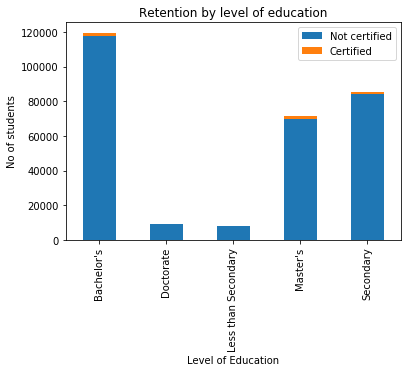

In [136]:
df_loe = df.groupby(['LoE_DI','certified'])['course_id'].count().unstack()
loe_plot = df_loe.plot(kind='bar',stacked=True,title="Retention by level of education",rot=90)
loe_plot.set_xlabel("Level of Education")
loe_plot.set_ylabel("No of students")
#loe_plot.set_ylim((10000, 250000))
loe_plot.legend(["Not certified","Certified"]);

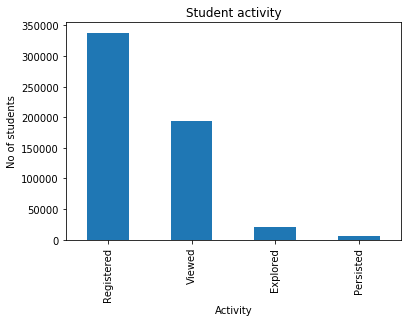

In [137]:
#student activity
registered = df[df['registered']==1]['course_id'].count()
viewed = df[df['viewed']==1]['course_id'].count()
explored = df[df['explored']==1]['course_id'].count()
persisted = df[df['certified']==1]['course_id'].count()

#build df
df_progress = pd.DataFrame([['Registered',registered],
               ['Viewed',viewed],
               ['Explored',explored],
              ['Persisted',persisted]], columns=
['student_progress', 'count'])

#set index
df_progress = df_progress.set_index('student_progress')

#plot
progress_plot = df_progress.plot(kind='bar',stacked=True,title="Student activity",rot=90,legend=False);
progress_plot.set_xlabel("Activity")
progress_plot.set_ylabel("No of students");

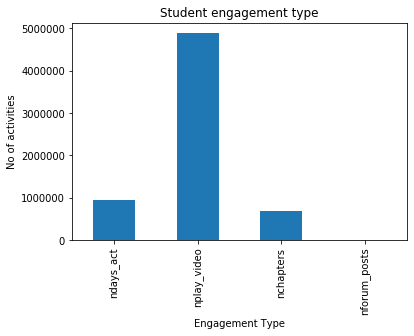

In [138]:
#student activity
#nevents = df['nevents'].sum()
ndays_act = df['ndays_act'].sum()
nplay_video = df['nplay_video'].sum()
nchapters = df['nchapters'].sum()
nforum_posts = df['nforum_posts'].sum()

#build df
df_activity_progress = pd.DataFrame([
               ['ndays_act',ndays_act],
               ['nplay_video',nplay_video],
              ['nchapters',nchapters],
              ['nforum_posts',nforum_posts]],            
            columns= ['student_activity_progress', 'count'])

#set index
df_activity_progress = df_activity_progress.set_index('student_activity_progress')

#plot
activity_progress_plot = df_activity_progress.plot(kind='bar',stacked=True,title="Student engagement type",rot=90,legend=False);
activity_progress_plot.set_xlabel("Engagement Type")
activity_progress_plot.set_ylabel("No of activities");

### Key feature statistics

In [139]:
df['age'].describe()

count    299719.000000
mean         28.955275
std           9.603730
min           0.000000
25%          22.000000
50%          27.000000
75%          33.000000
max          82.000000
Name: age, dtype: float64

In [140]:
df['nevents'].describe()

count    178945.000000
mean        231.992702
std         939.101311
min           1.000000
25%           3.000000
50%          17.000000
75%          95.000000
max       43880.000000
Name: nevents, dtype: float64

In [141]:
df['nplay_video'].describe()

count    33277.000000
mean       146.964179
std        518.468002
min          1.000000
25%          4.000000
50%         17.000000
75%         74.000000
max      34596.000000
Name: nplay_video, dtype: float64

In [142]:
df['nchapters'].describe()

count    193758.000000
mean          3.487727
std           4.720403
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          34.000000
Name: nchapters, dtype: float64

### Feature correlation

In [143]:
df.corr()

,registered,viewed,explored,certified,YoB,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag,age
registered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
viewed,NaN,1.000000,0.219908,0.121460,-0.006711,0.151474,0.194616,0.001522,0.021805,0.064513,NaN,NaN,0.006711
explored,NaN,0.219908,1.000000,0.504517,-0.004783,0.453486,0.545108,0.416503,0.757574,0.065524,NaN,NaN,0.004783
certified,NaN,0.121460,0.504517,1.000000,-0.000931,0.496904,0.551765,0.366351,0.579548,0.076593,NaN,NaN,0.000931
YoB,NaN,-0.006711,-0.004783,-0.000931,1.000000,-0.042212,-0.058725,-0.041638,-0.035461,0.022356,NaN,NaN,-1.000000
nevents,NaN,0.151474,0.453486,0.496904,-0.042212,1.000000,0.718681,0.814174,0.444501,0.087138,NaN,NaN,0.042212
ndays_act,NaN,0.194616,0.545108,0.551765,-0.058725,0.718681,1.000000,0.625898,0.607456,0.102466,NaN,NaN,0.058725
nplay_video,NaN,0.001522,0.416503,0.366351,-0.041638,0.814174,0.625898,1.000000,0.500819,0.075744,NaN,NaN,0.041638
nchapters,NaN,0.021805,0.757574,0.579548,-0.035461,0.444501,0.607456,0.500819,1.000000,0.133339,NaN,NaN,0.035461
nforum_posts,NaN,0.064513,0.065524,0.076593,0.022356,0.087138,0.102466,0.075744,0.133339,1.000000,NaN,NaN,-0.022356


### Hypothesis testing

In [144]:
#Hypothesis testing: Age has no impact on retention
print("Null Hypothesis: Age has no impact on retention")
print("\n")
#drop age na.
df_age_hypo_test = df.dropna(subset=['age'])

#random sample of 1000 students who have persisted
persisters_age =np.asarray(df_age_hypo_test[df_age_hypo_test['certified']==1].sample(1000)['age'])

#random sample of 1000 students who have not persisted
non_persisters_age =np.asarray(df_age_hypo_test[df_age_hypo_test['certified']!=1].sample(1000)['age'])

#non_persisters mean
non_persisters_age_mean = np.mean(non_persisters_age)
#persisters mean
persisters_age_mean = np.mean(persisters_age)

#non_persisters std
non_persisters_age_std = np.std(non_persisters_age)
#persisters std
persisters_age_std = np.std(persisters_age)

ttest,pval = ttest_ind(non_persisters_age,persisters_age)


print("non_persisters_age mean value:",non_persisters_age_mean)
print("persisters_age mean value:",persisters_age_mean)
print("\n")

print("non_persisters_age std value:",non_persisters_age_std)
print("persisters_age std value:",persisters_age_std)

print("\n")

print("p-value",pval)

print("\n")

if pval <0.05:
  print("We reject null hypothesis")
else:
  print("We accept null hypothesis")

Null Hypothesis: Age has no impact on retention


non_persisters_age mean value: 28.677
persisters_age mean value: 28.855


non_persisters_age std value: 9.316795103467715
persisters_age std value: 9.027290568049752


p-value 0.6645689550933813


We accept null hypothesis


In [145]:
#Hypothesis testing: Gender has no impact on retention
print("Null Hypothesis: Gender has no impact on retention")
print("\n")
#drop age na.
df_gender_hypo_test = df.dropna(subset=['gender'])
df_gender_hypo_test["gender"].replace({"m": 1, "f": 0, "o": 0}, inplace=True)

#random sample of 1000 students who have persisted
persisters_gender =np.asarray(df_gender_hypo_test[df_gender_hypo_test['certified']==1].sample(1000)['gender'])

#random sample of 1000 students who have not persisted
non_persisters_gender =np.asarray(df_gender_hypo_test[df_gender_hypo_test['certified']!=1].sample(1000)['gender'])

#non_persisters mean
non_persisters_gender_mean = np.mean(non_persisters_gender)
#persisters mean
persisters_gender_mean = np.mean(persisters_gender)

#non_persisters std
non_persisters_gender_std = np.std(non_persisters_gender)
#persisters std
persisters_gender_std = np.std(persisters_gender)

ttest,pval = ttest_ind(non_persisters_gender,persisters_gender)


print("non_persisters_gender mean value:",non_persisters_gender_mean)
print("persisters_gender mean value:",persisters_gender_mean)
print("\n")

print("non_persisters_gender std value:",non_persisters_gender_std)
print("persisters_age std value:",persisters_gender_std)

print("\n")

print("p-value",pval)

print("\n")

if pval <0.05:
  print("We reject null hypothesis")
else:
  print("We accept null hypothesis")

Null Hypothesis: Gender has no impact on retention


non_persisters_gender mean value: 0.681
persisters_gender mean value: 0.667


non_persisters_gender std value: 0.4660890472860309
persisters_age std value: 0.4712865370451398


p-value 0.5044767182978747


We accept null hypothesis


/Users/pshetty/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [146]:
#Hypothesis testing: events has no impact on retention
print("Null Hypothesis: Activities or events has no impact on retention")
print("\n")
#drop events na.
df_events_hypo_test = df.dropna(subset=['nevents'])

#random sample of 1000 students who have persisted
persisters_events =np.asarray(df_events_hypo_test[df_events_hypo_test['certified']==1].sample(1000)['nevents'])

#random sample of 1000 students who have not persisted
non_persisters_events =np.asarray(df_events_hypo_test[df_events_hypo_test['certified']!=1].sample(1000)['nevents'])

#non_persisters mean
non_persisters_events_mean = np.mean(non_persisters_events)
#persisters mean
persisters_events_mean = np.mean(persisters_events)

#non_persisters std
non_persisters_events_std = np.std(non_persisters_events)
#persisters std
persisters_events_std = np.std(persisters_events)

ttest,pval = ttest_ind(non_persisters_events,persisters_events)


print("non_persisters_events mean value:",non_persisters_events_mean)
print("persisters_events mean value:",persisters_events_mean)
print("\n")

print("non_persisters_events std value:",non_persisters_events_std)
print("persisters_events std value:",persisters_events_std)

print("\n")

print("p-value",pval)

print("\n")

if pval <0.05:
  print("We reject null hypothesis")
else:
  print("We accept null hypothesis")

Null Hypothesis: Activities or events has no impact on retention


non_persisters_events mean value: 164.787
persisters_events mean value: 2546.315


non_persisters_events std value: 801.2754155912934
persisters_events std value: 3001.605117562102


p-value 6.4769614041372354e-114


We reject null hypothesis


In [147]:
#Hypothesis testing: grades has no impact on retention
print("Null Hypothesis: grades have no impact on retention")
print("\n")
#drop events na.
df_grade_hypo_test = df.dropna(subset=['grade'])

#random sample of 1000 students who have persisted
persisters_grade =np.asarray(df_grade_hypo_test[df_grade_hypo_test['certified']==1].sample(1000)['grade'])

#random sample of 1000 students who have not persisted
non_persisters_grade =np.asarray(df_grade_hypo_test[df_grade_hypo_test['certified']!=1].sample(1000)['grade'])

#replace ' ' with '0'
non_persisters_grade = np.where(non_persisters_grade==' ', '0', non_persisters_grade)
# change datatype to float
non_persisters_grade = non_persisters_grade.astype(np.float)

#non_persisters mean
non_persisters_grade_mean = np.mean(non_persisters_grade)


#replace ' ' with '0'
persisters_grade = np.where(persisters_grade==' ', '0', persisters_grade)
# change datatype to float
persisters_grade = persisters_grade.astype(np.float)

#persisters mean
persisters_grade_mean = np.mean(persisters_grade)

#non_persisters std
non_persisters_grade_std = np.std(non_persisters_grade)
#persisters std
persisters_grade_std = np.std(persisters_grade)

ttest,pval = ttest_ind(non_persisters_grade,persisters_grade)


print("non_persisters_grade mean value:",non_persisters_grade_mean)
print("persisters_grade mean value:",persisters_grade_mean)
print("\n")

print("non_persisters_grade std value:",non_persisters_grade_std)
print("persisters_grade std value:",persisters_grade_std)

print("\n")

print("p-value",pval)

print("\n")

if pval <0.05:
  print("We reject null hypothesis")
else:
  print("We accept null hypothesis")


Null Hypothesis: grades have no impact on retention


non_persisters_grade mean value: 0.00552
persisters_grade mean value: 0.8745899999999999


non_persisters_grade std value: 0.03898883942873909
persisters_grade std value: 0.12749522304776756


p-value 0.0


We reject null hypothesis


### Preprocess data

#### 1. Handle NAs and nulls

In [148]:
X =df.copy()
# drop these columns as they are sparse.
X.drop(columns=['roles', 'incomplete_flag','age_bucket'],inplace=True)

# replace 'NaN' with zero for these columns
cols_fillna = ['grade','nevents','ndays_act','nplay_video','nchapters','nforum_posts']
for col in cols_fillna:
    X[col].fillna(0,inplace=True)

# impute column last_event_DI. If it's blank, replace with start_time_DI
X['last_event_DI'] = np.where(X['last_event_DI'].isnull(), X['start_time_DI'], X['last_event_DI'])

#drop rows with na values. At this point the records that will get dropped are minimal
X.dropna(inplace=True)
X.shape

(290948, 19)

#### 2. Transform data, handle categorical variables

In [149]:
# data transformation
# Create a new column which is the difference of last_event_DI and start_time_DI. We can then 
# drop start_time_DI and last_event_DI
X['last_event'] = (X['last_event_DI'].astype('datetime64[ns]') - X['start_time_DI'].astype('datetime64[ns]')).astype(int)
X['last_event'] = X['last_event']/100000000000000.0

#drop start_time_DI and last_event_DI
X.drop(columns=['start_time_DI', 'last_event_DI'],inplace=True)

#encode categorical values using "label encoding"
#https://www.datacamp.com/community/tutorials/categorical-data
X['course_id'] = X['course_id'].astype('category')
X['course_id'] = X['course_id'].cat.codes

X['final_cc_cname_DI'] = X['final_cc_cname_DI'].astype('category')
X['final_cc_cname_DI'] = X['final_cc_cname_DI'].cat.codes

X['gender'] = X['gender'].astype('category')
X['gender'] = X['gender'].cat.codes

X['LoE_DI'] = X['LoE_DI'].astype('category')
X['LoE_DI'] = X['LoE_DI'].cat.codes

#update userid to remove strings
X['userid_DI'] = X['userid_DI'].str.slice(start=5)

#change ' ' values in grade column to 0
X['grade'] = np.where(X['grade'] ==' ', '0', X['grade'])

#change datatype to int
X['userid_DI'] = X['userid_DI'].astype('int')
X['grade'] = X['grade'].astype('float')

In [150]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290948 entries, 1880 to 338221
Data columns (total 18 columns):
course_id            290948 non-null int8
userid_DI            290948 non-null int64
registered           290948 non-null int64
viewed               290948 non-null int64
explored             290948 non-null int64
certified            290948 non-null int64
final_cc_cname_DI    290948 non-null int8
LoE_DI               290948 non-null int8
YoB                  290948 non-null float64
gender               290948 non-null int8
grade                290948 non-null float64
nevents              290948 non-null float64
ndays_act            290948 non-null float64
nplay_video          290948 non-null float64
nchapters            290948 non-null float64
nforum_posts         290948 non-null int64
age                  290948 non-null float64
last_event           290948 non-null float64
dtypes: float64(8), int64(6), int8(4)
memory usage: 34.4 MB


In [151]:
#get the target
y = X.pop('certified')

#### 3. Handle imbalanced dataset

In [152]:
#counter = Counter(y)
#print(counter)
#print("Event Rate", round(5728/285220,3))
#Balance dataset
#https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/
#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
#counter = Counter(y)
#print(counter)
#print("New event Rate", round(285220/285220,3))

In [153]:
X_scaled = preprocessing.scale(X)

In [154]:
X_scaled

array([[-1.45885606, -1.32605908,  0.        , ..., -0.07585254,
        -1.0352413 , -0.03368992],
       [-1.45885606, -1.06693833,  0.        , ..., -0.07585254,
        -0.61923654,  0.40176713],
       [-1.45885606, -1.0189588 ,  0.        , ..., -0.07585254,
         0.62877776, -0.48275501],
       ...,
       [ 1.9571475 ,  0.76619956,  0.        , ..., -0.07585254,
        -0.61923654, -0.29224255],
       [ 1.9571475 , -1.70586176,  0.        , ..., -0.07585254,
        -0.41123415, -0.48275501],
       [ 1.9571475 ,  0.51928957,  0.        , ..., -0.07585254,
        -0.20323177, -0.48275501]])

In [155]:
#store column names
feature_columns =['course_id', 'userid_DI', 'registered'
          , 'viewed', 'explored', 'final_cc_cname_DI'
          , 'LoE_DI', 'YoB', 'gender', 'grade', 'nevents', 'ndays_act'
          , 'nplay_video', 'nchapters', 'nforum_posts', 'last_event']
#get training and test data
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=0)

### ML models

#### 1.Logistic Regression

In [156]:
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_test)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print("Logistic Regression:")
print("Accuracy ",round(score,5))
print("Recall",round(recall_score(y_test, y_pred, average='macro'),5))
print("Precision",round(precision_score(y_test, y_pred, average='macro'),5)) 

Logistic Regression:
Accuracy  0.99855
Recall 0.9857
Precision 0.9766


In [157]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None).ravel()
(tn, fp, fn, tp)

(142521, 133, 78, 2742)

In [158]:
# Get the top 5 features based on feature coefficients
#https://stackoverflow.com/questions/34649969/how-to-find-the-features-names-of-the-coefficients-using-scikit-linear-regressio
coef_dict = {}
for coef, feat in zip(logisticRegr.coef_[0,:],feature_columns):
    coef_dict[feat] = coef
print("Top 5 Logistic Regression features based on feature coefficients:")
sorted(coef_dict, key=lambda dict_key: abs(coef_dict[dict_key]), reverse=True)[:5]

Top 5 Logistic Regression features based on feature coefficients:


['grade', 'viewed', 'explored', 'final_cc_cname_DI', 'nevents']

#### 2.Random Forest

In [159]:
randomClassifier = RandomForestClassifier(n_estimators=100, 
                               random_state=50, 
                               max_features = 'sqrt',
                               n_jobs=-1)
randomClassifier.fit(x_train, y_train)
y_pred = randomClassifier.predict(x_test)
# Use score method to get accuracy of model
score = randomClassifier.score(x_test, y_test)
print("RandomForest Classifier:")
print("Accuracy ",round(score,5))
print("Recall",round(recall_score(y_test, y_pred, average='macro'),5))
print("Precision",round(precision_score(y_test, y_pred, average='macro'),5))

RandomForest Classifier:
Accuracy  0.99997
Recall 0.99946
Precision 0.99981


In [160]:
# Get the top 5 features
rf_feat_imp = randomClassifier.feature_importances_
rf_feat_imp = np.reshape(rf_feat_imp, (1,17))

coef_dict = {}
for coef, feat in zip(rf_feat_imp[0,:],feature_columns):
    coef_dict[feat] = coef
print("Top 5 Random Forest features based on feature importance:")
sorted(coef_dict, key=lambda dict_key: abs(coef_dict[dict_key]), reverse=True)[:5]

Top 5 Random Forest features based on feature importance:


['grade', 'nevents', 'nchapters', 'ndays_act', 'explored']

#### 3. Support Vector Machine(SVM)

In [161]:
svmClassifier = svm.SVC(kernel='linear')
svmClassifier.fit(x_train, y_train)
y_pred = svmClassifier.predict(x_test)
# Use score method to get accuracy of model
score = svmClassifier.score(x_test, y_test)
print("SVM(Support Vector Machine) Classifier:")
print("Accuracy ",round(score,5))
print("Recall",round(recall_score(y_test, y_pred, average='macro'),5))
print("Precision",round(precision_score(y_test, y_pred, average='macro'),5))

SVM(Support Vector Machine) Classifier:
Accuracy  0.99863
Recall 0.98731
Precision 0.97703


In [162]:
# Get the top 5 features for SVM
coef_dict = {}
for coef, feat in zip(svmClassifier.coef_[0,:],feature_columns):
    coef_dict[feat] = coef
print("Top 5 SVM(Support Vector Machine):")
sorted(coef_dict, key=lambda dict_key: abs(coef_dict[dict_key]), reverse=True)[:5]

Top 5 SVM(Support Vector Machine):


['grade', 'explored', 'course_id', 'nevents', 'final_cc_cname_DI']

#### 4. XGBoost

In [163]:
xgboostClassifier = XGBClassifier()
xgboostClassifier.fit(x_train, y_train)
y_pred = xgboostClassifier.predict(x_test)
# Use score method to get accuracy of model
score = xgboostClassifier.score(x_test, y_test)
print("XGBoost Classifier:")
print("Accuracy ",round(score,10))
print("Recall",round(recall_score(y_test, y_pred, average='macro'),10))
print("Precision",round(precision_score(y_test, y_pred, average='macro'),10))

XGBoost Classifier:
Accuracy  1.0
Recall 1.0
Precision 1.0


In [164]:
# Get the top 5 features for SVM
xgboost_feat_imp = xgboostClassifier.feature_importances_
xgboost_feat_imp = np.reshape(xgboost_feat_imp, (1,17))

coef_dict = {}
for coef, feat in zip(xgboost_feat_imp[0,:],feature_columns):
    coef_dict[feat] = coef
print("Top 5 XGBoost features:")
sorted(coef_dict, key=lambda dict_key: abs(coef_dict[dict_key]), reverse=True)[:5]

Top 5 XGBoost features:


['grade', 'course_id', 'nevents', 'nchapters', 'nplay_video']

In [165]:
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_test)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print("Logistic Regression:")
print("Accuracy ",round(score,5))
print("Recall",round(recall_score(y_test, y_pred, average='macro'),5))
print("Precision",round(precision_score(y_test, y_pred, average='macro'),5)) 





Logistic Regression:
Accuracy  0.99855
Recall 0.9857
Precision 0.9766


### Test results using 5 fold cross validation

In [ ]:

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = KFold(n_splits=5)
logisticRegr =LogisticRegression()#RandomForestClassifier(n_estimators=50) 
randomClassifier = RandomForestClassifier(n_estimators=100, 
                               random_state=50, 
                               max_features = 'sqrt',
                               n_jobs=-1)
svmClassifier = svm.SVC(kernel='linear')
xgboostClassifier = XGBClassifier()

logistic_results = cross_validate(estimator=logisticRegr,
                                          X=X_scaled,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)

RF_results = cross_validate(estimator=randomClassifier,
                                          X=X_scaled,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)

SVM_results = cross_validate(estimator=svmClassifier,
                                          X=X_scaled,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)

XGBoost_results = cross_validate(estimator=xgboostClassifier,
                                          X=X_scaled,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)



In [ ]:
print("Logistic regression cross validation results:")
print("Accuracy: ",logistic_results['test_accuracy'].mean())
print("Precision: ",logistic_results['test_precision'].mean())
print("Recall: ",logistic_results['test_recall'].mean())
print("F1_score: ",logistic_results['test_f1_score'].mean())

print("\n")

print("Random Forest cross validation results:")
print("Accuracy: ",RF_results['test_accuracy'].mean())
print("Precision: ",RF_results['test_precision'].mean())
print("Recall: ",RF_results['test_recall'].mean())
print("F1_score: ",RF_results['test_f1_score'].mean())

print("\n\n")

print("Support Vector Machines cross validation results:")
print("Accuracy: ",SVM_results['test_accuracy'].mean())
print("Precision: ",SVM_results['test_precision'].mean())
print("Recall: ",SVM_results['test_recall'].mean())
print("F1_score: ",SVM_results['test_f1_score'].mean())

print("\n\n")

print("XGBoost cross validation results:")
print("Accuracy: ",XGBoost_results['test_accuracy'].mean())
print("Precision: ",XGBoost_results['test_precision'].mean())
print("Recall: ",XGBoost_results['test_recall'].mean())
print("F1_score: ",XGBoost_results['test_f1_score'].mean())

#### Since we have a imbalanced dataset, ie. the number of students who got certified are far less than students who didn’t certify, we need to make sure the minority class accuracy is correct. Hence we rely on test parameters like precision and recall. F1 score represents both these parameters and hence we use this to evaluate our models.
#### Based on F1 score, Random Forest and XGBoost have the best performance in predicting student retention.
